Authors: Nicola Cassetta, Andrea Di Trani 

##Imports

In [1]:
!pip install --upgrade --no-cache-dir gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


In [2]:
!pip install -q transformers datasets pytorch-lightning
!pip install -q beautifulsoup4 pip install lxml

import pytorch_lightning as pl, transformers as tr, pandas as pd
model_name='google/vit-base-patch16-224'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 57.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 51.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.8/825.8 KB 64.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 48.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 52.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 16.7 MB/s eta 0:00:00


In [3]:
import glob
import xml.etree.ElementTree as ET
import PIL
from PIL import Image, ImageChops
from google.colab import drive
import os
import cv2
import gc
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import math
import time
from pathlib import Path
import shutil
import pandas as pd
import pickle
import sklearn.metrics
import torchvision
import torch.utils.data
import torch.nn as nn
import torch
import zipfile
import requests
import gdown
import tensorflow_hub as hub

##CUDA settings

In [4]:
if torch.cuda.is_available():
  dev = torch.device("cuda")
  name = torch.cuda.get_device_name(0)
  dev = 'cuda:0'
  print(dev, name)
else:
  dev = "cpu"
  print(dev)

cuda:0 Tesla T4


In [5]:
!nvidia-smi

Mon Feb 13 08:53:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P0    27W /  70W |      3MiB / 15360MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

##Utility Functions 

In [6]:
drive.mount('/content/drive', force_remount=True)
MAIN_PATH = '/content/drive/MyDrive/UNIPD_Projects/Decepticon'

Mounted at /content/drive


In [7]:
lab_name_xml = pd.read_csv(MAIN_PATH + '/utils/syntets_name.txt', sep=':', header=None)

with open(os.path.join(MAIN_PATH, 'label_dict.pkl'), 'rb') as f:
    lab_name_n = pickle.load(f)


def get_label_name(label, from_xml=True):
  if from_xml:
    name = lab_name_xml[lab_name_xml[0] == label][1]
    return name.item().strip()

  else:
    name = lab_name_n[label]
    return name.strip()


def synset_to_n(synset):
  out = []
  keys = list(lab_name_n.keys())
  values = list(lab_name_n.values())

  for i in synset:
    name = get_label_name(i)
    out.append(keys[values.index(name)]+1)

  return out


def get_val_xml(item, parent = "object", child = "name"):
  tree = ET.parse(item)
  root = tree.getroot()

  for obj in root.findall(parent):
    id = obj.find(child).text

  return id


def load_and_resize(source_path, size, dest_path):
  for i, (dirpath, dirnames, filenames) in enumerate(os.walk(source_path)):  
    for filee in filenames:      
      im = cv2.imread(os.path.join(dirpath, filee))
      im = cv2.resize(im, (size,size))

      new_name = str(dest_path + "img_" + filee.split("_")[2])

      cv2.imwrite(new_name, im)


def load_label(source_path, dest_path):
  for i, (dirpath, dirnames, filenames) in enumerate(os.walk(source_path)):  
    for filee in filenames:
      new_name = str(dest_path + "lab_" + filee.split("_")[2])
      shutil.copyfile(os.path.join(dirpath, filee), new_name)


def diff_img(img_true, img_pred):
  f, axarr = plt.subplots(1,3, figsize=(15, 15))
  axarr[0].imshow(img_true)
  axarr[1].imshow(img_pred)
  axarr[2].imshow(ImageChops.difference(img_true, img_pred))
  plt.show()


def L2Norm(H1,H2):
    distance = 0
    for i in range(len(H1)):
        distance += np.square(H1[i]-H2[i])
    return np.sqrt(distance)

def get_diff_stat(img_start, img_end):
  arr_start = np.array(img_start)
  arr_end = np.array(img_end)

  mat = np.zeros([256,256])
  mat_loc = np.zeros([256,256])

  for i in range(256):
    for j in range(256):
      mat[i,j] = L2Norm(arr_start[i,j]/255, arr_end[i,j]/255)
  
  avg = np.mean(mat)
  mat_loc = mat>0
  n_pix = np.sum(mat_loc)

  return avg, n_pix

def difference_maps(img_start, img_end, fig_size = (10,10), enhance = 1, space = 0.2, save = False, name = None, path = None, save_t=True):

  arr_start = np.array(img_start)
  arr_end = np.array(img_end)

  mat = np.zeros([256,256])
  mat_loc = np.zeros([256,256])

  for i in range(256):
    for j in range(256):
      mat[i,j] = L2Norm(arr_start[i,j]/255, arr_end[i,j]/255) * enhance

  mat_loc = (mat > 0)

  
  if save:
    
    img_end.save(os.path.join(path,str(name),str(name)+'_final.png'))
    plt.imsave(os.path.join(path,str(name),str(name)+'_int_map.png'), mat, cmap="inferno")
    plt.imsave(os.path.join(path,str(name),str(name)+'_cng_map.png'), mat_loc, cmap="Greens")
  elif save_t:
    dir = os.path.join(path,str(name))
    os.mkdir(dir)
    f, axarr = plt.subplots(2,2, figsize = fig_size)
    plt.subplots_adjust(hspace = space, wspace = space)
    axarr[0,0].set_title("Input img", loc='center')
    ims = axarr[0,0].imshow(img_start)
    axarr[0,1].set_title("Final img", loc='center')
    ime = axarr[0,1].imshow(img_end)

    axarr[1,0].set_title("Per-Pixel change intensity", loc='center')
    im0 = axarr[1,0].imshow(mat, "inferno")
    plt.colorbar(im0, ax=axarr[1,0], fraction=0.046, pad=0.04)

    title = "Checkmap of changed pixel: " + str(np.sum(mat_loc))
    axarr[1,1].set_title(title, loc='center')
    im1 = axarr[1,1].imshow(mat_loc, "Greens")

    f.savefig(os.path.join(path,str(name),str(name)+'_figure.png'), bbox_inches='tight')
    plt.close()
  else:
    f, axarr = plt.subplots(2,2, figsize = fig_size)
    plt.subplots_adjust(hspace = space, wspace = space)
    axarr[0,0].set_title("Input img", loc='center')
    ims = axarr[0,0].imshow(img_start)
    axarr[0,1].set_title("Final img", loc='center')
    ime = axarr[0,1].imshow(img_end)

    axarr[1,0].set_title("Per-Pixel change intensity", loc='center')
    im0 = axarr[1,0].imshow(mat, "inferno")
    plt.colorbar(im0, ax=axarr[1,0], fraction=0.046, pad=0.04)

    title = "Checkmap of changed pixel: " + str(np.sum(mat_loc))
    axarr[1,1].set_title(title, loc='center')
    im1 = axarr[1,1].imshow(mat_loc, "Greens")
    plt.show()

  if(enhance != 1):
    print("\nChanges in pixel intensity have been increased by: ", enhance)

  return mat, mat_loc


def plot_graphs (diz, fig_size, space = 0.2):
  
  f, axarr = plt.subplots(1,2, figsize = fig_size)
  plt.subplots_adjust(hspace = space, wspace = space)

  axarr[0].set_title("Loss", loc='center')
  ims = axarr[0].plot(diz['loss_hist'])

  axarr[1].set_title("Norm diff", loc='center')
  ime = axarr[1].plot(diz['diff'])
  
  plt.show()

def n_pix_diff(diff):
  s = torch.sum(diff, dim=0)
  return s[s != 0].size()[0]

def make_desc(n_iter, step, eps, dist, line_search, path, name, beta):
  desc = ['MAX_ITER: '+str(n_iter),
          'NORM: '+str(dist),
          'EPS: '+str(eps),
          'LINE_SEARCH: '+str(line_search),
          'STEP_SIZE: '+str(step),
          'MOMENTUM: '+str(beta)]
  with open(os.path.join(path,name+'.txt'), 'w') as f:
    for s in desc:
      f.write(s)
      f.write('\n')

def generate_test_name(iter, norm, eps, line_search, step_size, beta):
  name = str(iter)+'_'
  if len(str(norm)) >= 3:
    n = str(norm).upper()
  else:
    n = 'L'+str(norm)
  name = name+n+'_'
  e = 'E'+str(eps).replace('0.','')
  name = name+e+'_'
  l = line_search[0:3].upper()
  s = str(step_size).replace('0.','')
  name = name+l+s+'_'
  m = 'M'+str(beta).replace('0.', '')
  name = name+m
  return name

def get_success_rate(dict_list, max_iter=100):
  n_s = 0
  for d in dict_list:
    if d['exit'] == 'error' and len(d['loss_hist'])<max_iter:
      n_s = n_s + 1
  
  return n_s/100

def select_tests(feat_dict, full_dict, all=False):
  names = list(test_dict.keys())
  tmp = names.copy()
  for n in names:
    v=True
    for d in feature_dict['dist']:
      if d in n:
        v=False
    if v:
      tmp.remove(n)
  names = tmp.copy()
  print(len(names))

  for n in range(len(names)):
    v=True
    for d in feature_dict['line_search']:
      if d in names[n]:
        v=False
    if v:
      tmp.remove(names[n])
  names = tmp.copy()
  print(n)

  for n in names:
    v=True
    for d in feature_dict['eps']:
      if 'E'+d in n:
        v=False
    if v:
      tmp.remove(n)
  names=tmp.copy()

  return names

def avg_time(dict_list, only_success=False):
  time = []
  for s in range(len(dict_list)):
    if only_success:
      if dict_list[s]['exit'] == 'error': 
        time.append(dict_list[s]['time'][-1])
    else:
      time.append(dict_list[s]['time'][-1])

  time = sum(time)/len(time)
  return round(time,2)

def avg_iter(dict_list, only_success=False):
  time = []
  for s in range(len(dict_list)):
    if only_success:
      if dict_list[s]['exit'] == 'error': 
        time.append(len(dict_list[s]['time']))
    else:
      time.append(len(dict_list[s]['time']))

  time = sum(time)/len(time)
  return round(time,2)

def avg_pix(dict_list, only_success=False):
  time = []
  for s in range(len(dict_list)):
    if only_success:
      if dict_list[s]['exit'] == 'error': 
        time.append(dict_list[s]['n_pix_diff'])
    else:
      time.append(dict_list[s]['n_pix_diff'])

  time = sum(time)/len(time)
  return round(time,2)

def avg_int(dict_list, only_success=False):
  time = []
  for s in range(len(dict_list)):
    if only_success:
      if dict_list[s]['exit'] == 'error': 
        time.append(dict_list[s]['avg_intensity'])
    else:
      time.append(dict_list[s]['avg_intensity'])

  time = sum(time)/len(time)
  return round(time,3)



In [8]:
def hm_to_coords(hm, treshold, coords=True):

  loc = np.array(hm)/255
  #loc = np.transpose(loc, (2,1,0))
  loc = np.moveaxis(loc, -1, 0)
  loc = loc[0:3,:,:]
  loc[np.where(loc <= treshold)] = 0

  if coords:
    loc[np.where(np.logical_and(loc > treshold, loc <= np.max(loc)))] = 1
    out = np.where(loc >= 1)
  else:
    out = loc

  
  return out

## Attention Functions

In [49]:
RESOLUTION = 224
PATCH_SIZE = 16

In [50]:
def get_tfhub_model(model_url: str) -> tf.keras.Model:
    inputs = keras.Input((RESOLUTION, RESOLUTION, 3))
    hub_module = hub.KerasLayer(model_url)
    outputs, attention_weights = hub_module(inputs)
    return keras.Model(inputs, outputs=[outputs, attention_weights])


def get_gdrive_model(model_id: str) -> tf.keras.Model:
    model_path = gdown.download(id=model_id, quiet=False)
    with zipfile.ZipFile(model_path, "r") as zip_ref:
        zip_ref.extractall()
    model_name = model_path.split(".")[0]
    inputs = keras.Input((RESOLUTION, RESOLUTION, 3))
    model = keras.models.load_model(model_name, compile=False)
    outputs, attention_weights = model(inputs)
    return keras.Model(inputs, outputs=[outputs, attention_weights])

def get_model(url_or_id):
    if "https" in url_or_id:
        loaded_model = get_tfhub_model(url_or_id)
    else:
        loaded_model = get_gdrive_model(url_or_id)
    return loaded_model

# Load the model.
vit_dino_base16 = get_model("16_1oDm0PeCGJ_KGBG5UKVN7TsAtiRNrN")
print("Models loaded.")

Downloading...
From: https://drive.google.com/uc?id=16_1oDm0PeCGJ_KGBG5UKVN7TsAtiRNrN
To: /content/vit_dino_base16.zip
100%|██████████| 326M/326M [00:08<00:00, 37.7MB/s]


Models loaded.


In [51]:
crop_layer = keras.layers.CenterCrop(RESOLUTION, RESOLUTION)
norm_layer = keras.layers.Normalization(
    mean=[0.485 * 255, 0.456 * 255, 0.406 * 255],
    variance=[(0.229 * 255) ** 2, (0.224 * 255) ** 2, (0.225 * 255) ** 2],
)
rescale_layer = keras.layers.Rescaling(scale=1.0 / 127.5, offset=-1)


def preprocess_image(image, model_type, size=RESOLUTION):
    # Turn the image into a numpy array and add batch dim.
    image = np.array(image)
    image = tf.expand_dims(image, 0)

    # If model type is vit rescale the image to [-1, 1].
    if model_type == "original_vit":
        image = rescale_layer(image)

    # Resize the image using bicubic interpolation.
    resize_size = int((256 / 224) * size)
    image = tf.image.resize(image, (resize_size, resize_size), method="bicubic")

    # Crop the image.
    image = crop_layer(image)

    # If model type is DeiT or DINO normalize the image.
    if model_type != "original_vit":
        image = norm_layer(image)

    return image.numpy()


In [52]:
def attention_heatmap(attention_score_dict, image, model_type="dino"):
    num_tokens = 2 if "distilled" in model_type else 1

    # Sort the Transformer blocks in order of their depth.
    attention_score_list = list(attention_score_dict.keys())
    attention_score_list.sort(key=lambda x: int(x.split("_")[-2]), reverse=True)

    # Process the attention maps for overlay.
    w_featmap = image.shape[2] // PATCH_SIZE
    h_featmap = image.shape[1] // PATCH_SIZE
    attention_scores = attention_score_dict[attention_score_list[0]]

    # Taking the representations from CLS token.
    attentions = attention_scores[0, :, 0, num_tokens:].reshape(12, -1)

    # Reshape the attention scores to resemble mini patches.
    attentions = attentions.reshape(12, w_featmap, h_featmap)
    attentions = attentions.transpose((1, 2, 0))

    # Resize the attention patches to 224x224 (224: 14x16).
    attentions = tf.image.resize(
        attentions, size=(h_featmap * PATCH_SIZE, w_featmap * PATCH_SIZE)
    )
    return attentions


# De-normalize the image for visual clarity.
def denormalize_img (img):
  in1k_mean = tf.constant([0.485 * 255, 0.456 * 255, 0.406 * 255])
  in1k_std = tf.constant([0.229 * 255, 0.224 * 255, 0.225 * 255])
  preprocessed_img_orig = (img * in1k_std) + in1k_mean
  preprocessed_img_orig = preprocessed_img_orig / 255.0
  preprocessed_img_orig = tf.clip_by_value(preprocessed_img_orig, 0.0, 1.0).numpy()

  return preprocessed_img_orig

In [53]:
def wrap_dino_attention (img_start):

  img_prep = preprocess_image(img_start, model_type = 'dino')
  # Grab the predictions.
  _, attention_score_dict = vit_dino_base16.predict(img_prep)
  # Generate the attention heatmaps.
  attentions = attention_heatmap(attention_score_dict, denormalize_img(img_prep))

  mul = 0
  for i in range(12):
    mul = mul + attentions[:,:,i]

  mask = mul.numpy()
  mask[np.where(np.logical_and(mask >= 0, mask <= 0.1))] = 0
  #mask[np.where(np.logical_and(mask > 0.1, mask <= np.max(mask)))] = 1

  mask_pad = np.lib.pad(mask, ((16,16),(16,16)), 'constant', constant_values=(0)) # Output

  return mask_pad

In [54]:
def gen_heatmap(img):

  img_prep = preprocess_image(img, model_type = 'dino')
  _, attention_score_dict = vit_dino_base16.predict(img_prep)
  attentions = attention_heatmap(attention_score_dict, denormalize_img(img_prep))

  mul = 0
  for i in range(12):
    mul = mul + attentions[:,:,i]

  return mul


'''
os.makedirs("/content/test_heatmaps/")
PATH_TEST_HEAT = "/content/test_heatmaps/"

for i in test_idx:

  name = "ht_" + str(test_names[i]) + "_testidx.png"

  tmp = gen_heatmap(test_imgs[i])
  fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
  axes.imshow(tmp, cmap="inferno")
  axes.axis("off")
  fig.savefig(PATH_TEST_HEAT+name, bbox_inches='tight', pad_inches=0)
'''

'''
heatmaps_test_list = []
heatmaps_test_names = []

for root, __, files in os.walk('/content/test_heatmaps_2/'):
  for f in files:
    if "ht_" in f:
      ls = f.split("_")
      im = Image.open(os.path.join(root, f))
      heatmaps_test_list.append(im.resize((256,256)))
      heatmaps_test_names.append(int(ls[1]))
'''

'\nheatmaps_test_list = []\nheatmaps_test_names = []\n\nfor root, __, files in os.walk(\'/content/test_heatmaps_2/\'):\n  for f in files:\n    if "ht_" in f:\n      ls = f.split("_")\n      im = Image.open(os.path.join(root, f))\n      heatmaps_test_list.append(im.resize((256,256)))\n      heatmaps_test_names.append(int(ls[1]))\n'

##Data load

In [9]:
shutil.copyfile(MAIN_PATH+'/val_resize.zip', '/content/val_resize.zip')
!mkdir 'val'
!unzip 'val_resize.zip' -d 'val'

img_list = []
img_names = []

for root, __, files in os.walk('/content/val/content/drive/MyDrive/UNIPD_Projects/Decepticon/val_resize'):
  for f in files:
    if "img_" in f:
      img_list.append(Image.open(os.path.join(root, f)))
      img_names.append(int(f.replace('img_', '').replace('.JPEG', '')))


img_names_sorted, img_list_sorted = zip(*sorted(zip(img_names, img_list)))

lis = pd.read_pickle(r'/content/drive/MyDrive/UNIPD_Projects/Decepticon/lab_dict')

Output streaming troncato alle ultime 5000 righe.
  inflating: val/content/drive/MyDrive/UNIPD_Projects/Decepticon/val_resize/img_00016045.JPEG  
  inflating: val/content/drive/MyDrive/UNIPD_Projects/Decepticon/val_resize/img_00003472.JPEG  
  inflating: val/content/drive/MyDrive/UNIPD_Projects/Decepticon/val_resize/img_00010081.JPEG  
  inflating: val/content/drive/MyDrive/UNIPD_Projects/Decepticon/val_resize/img_00034964.JPEG  
  inflating: val/content/drive/MyDrive/UNIPD_Projects/Decepticon/val_resize/img_00020538.JPEG  
  inflating: val/content/drive/MyDrive/UNIPD_Projects/Decepticon/val_resize/img_00039318.JPEG  
  inflating: val/content/drive/MyDrive/UNIPD_Projects/Decepticon/val_resize/img_00048320.JPEG  
  inflating: val/content/drive/MyDrive/UNIPD_Projects/Decepticon/val_resize/img_00026505.JPEG  
  inflating: val/content/drive/MyDrive/UNIPD_Projects/Decepticon/val_resize/img_00009097.JPEG  
  inflating: val/content/drive/MyDrive/UNIPD_Projects/Decepticon/val_resize/img_000231

In [ ]:
### TEST IMGS ####
shutil.copyfile(MAIN_PATH+'/test_imgs.zip', '/content/test_imgs.zip')
!mkdir 'test_imgs'
!unzip 'test_imgs.zip' -d 'test_imgs'

test_imgs = []
test_names = []

for root, __, files in os.walk('/content/test_imgs/test'):
  for f in files:
    test_imgs.append(Image.open(os.path.join(root, f)))
    test_names.append(int(f.replace('.png', '')))


In [ ]:
### HEATMAPS ###
shutil.copyfile(MAIN_PATH+'/heatmaps_resize.zip', '/content/heatmaps_resize.zip')
!mkdir 'heatmaps'
!unzip 'heatmaps_resize.zip' -d 'heatmaps'

heatmaps_list = []
heatmaps_names = []

for root, __, files in os.walk('/content/heatmaps/content/heatmaps_resize'):
  for f in files:
    if "hm_" in f:
      heatmaps_list.append(Image.open(os.path.join(root, f)))
      heatmaps_names.append(int(f.replace('hm_', '').replace('.png', '')))

In [ ]:
### TEST HEATMAPS ###
shutil.copyfile(MAIN_PATH+'/test_heatmaps.zip', '/content/test_heatmaps.zip')
!mkdir 'test_heatmaps'
!unzip 'test_heatmaps.zip' -d 'test_heatmaps'

heatmaps_test_list = []
heatmaps_test_names = []

for root, __, files in os.walk('/content/test_heatmaps/content/test_heatmaps'):
  for f in files:
    if "ht_" in f:
      ls = f.split("_")
      im = Image.open(os.path.join(root, f))
      heatmaps_test_list.append(im.resize((256,256)))
      heatmaps_test_names.append(int(ls[1]))

In [13]:
feature_extractor = tr.ViTFeatureExtractor.from_pretrained(model_name)

(feature_extractor.__dict__)

/usr/local/lib/python3.8/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


{'_processor_class': None,
 'do_resize': True,
 'do_rescale': True,
 'do_normalize': True,
 'size': {'height': 224, 'width': 224},
 'resample': 2,
 'rescale_factor': 0.00392156862745098,
 'image_mean': [0.5, 0.5, 0.5],
 'image_std': [0.5, 0.5, 0.5]}

In [14]:
compose = torchvision.transforms.Compose([
    torchvision.transforms.Resize(feature_extractor.size['height']),
    torchvision.transforms.CenterCrop(feature_extractor.size['height']),
    torchvision.transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
])


compose_img = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize(feature_extractor.size['height']),
    torchvision.transforms.CenterCrop(feature_extractor.size['height']),
    torchvision.transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
])

# Model Definition

In [15]:
model_name = 'google/vit-base-patch16-224'

In [16]:
class ViT(pl.LightningModule):
  def __init__(self):
    super(ViT, self).__init__()
    self.vit = tr.ViTForImageClassification.from_pretrained(model_name)
  
  def forward(self, pixel_values):
    logits = self.vit(pixel_values).logits
    return logits


  def common_step(self, batch, batch_idx):
        img = batch['image']
        labels = batch['label']
        logits = self(img)

        criterion = nn.CrossEntropyLoss()
        loss = criterion(logits, labels)
        predictions = logits.argmax(-1)
        correct = (predictions == labels).sum().item()
        accuracy = correct/img.shape[0]

        return loss, accuracy

  def training_step(self):
    return None

  def validation_step(self, batch, batch_idx):
    loss, accuracy = self.common_step(batch, batch_idx)     
    self.log("val_loss", loss, on_epoch=True)
    self.log("val_accuracy", accuracy, on_epoch=True)

    return loss

  def test_step(self, batch, batch_idx):
    loss, accuracy = self.common_step(batch, batch_idx)     
    self.log("test_loss", loss, on_epoch=True)
    self.log("test_accuracy", accuracy, on_epoch=True)
  
  def predict(self, batch):
    logits = self(batch)
    preds = logits.argmax(1)
    return preds, logits

    return loss

In [17]:
vit = ViT()

if(dev == "cuda:0"):
  vit = vit.cuda()

#Prediction

In [18]:
def pred_and_grad_single(dev, vit, img, label, loss, compose, obj_tens):

  img = obj_tens(img)
  img = img.to(dev)
  img.requires_grad=True

  tensor = compose(img).unsqueeze(0)
  tensor = tensor.to(dev)
  label = torch.tensor(label, device = dev)

  label = label.to(dev)

  pred, log = vit.predict(tensor)
  
  v = loss(log[0].to(dev), label)
  vit.zero_grad()
  v.backward()
  grad = img.grad

  pred = pred.clone().detach()
  grad = grad.clone().detach()

  del vit

  return [pred, grad, log, v.item()]

# Frank Wolfe

##FW_white

In [19]:
def FW_white (dev, vit, img_start, lab, loss, compose,
              n_iter, step_size, eps, beta = 0.99, line_search = 'fixed', dist = "inf",
              stop_condition = 'error', err_stop = 0.1, L = 1, verbosity=True):
  
  tens_lab = torch.tensor(lab, device = dev)

  obj_tens = torchvision.transforms.ToTensor()
  to_pil = torchvision.transforms.ToPILImage()

  tensor_start = obj_tens(img_start)
  tensor_start = tensor_start.to(dev)

  img_t = img_start
  tensor_t = obj_tens(img_t)
  tensor_t.to(dev)

  pred_t, grad_t, log_t, _ = pred_and_grad_single(dev, vit, img_t, lab, loss, compose, obj_tens)
  m_t = -grad_t

  loss_hist = []
  time_hist = []
  norm_diff_hist = []
  coords = []
  pix_diff = []

  if (line_search == 'adaptive'):
    sup_cf = L * ((2*eps)**2)

  elif (line_search == 'cumulative'):
    counter_lab = 0
  pred_t_1 = ''

  start = time.time()
  
  for t in range(n_iter):

    #print('------------ PRE ', t, 'PRE ------------')
    #print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    #print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

    #prediction, gradient and loss
    pred_t, grad_t, log_t, loss_t = pred_and_grad_single(dev, vit, img_t, lab, loss, compose, obj_tens)

    #print('------------ POST ------- POST ------------')
    #print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    #print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')
  
    #momentum update
    m_t = beta * m_t + (1-beta) * -grad_t

    #LMO computation
    if(dist == "nuc"):
      v_t = LMO_nuclear(tensor_start, m_t, eps)
    elif(dist == "inf"):
      v_t = LMO(tensor_start, m_t, eps)
    elif(dist == 2):
      v_t = LMO_2(tensor_start, m_t, eps)
    elif(dist == 1):
      v_t, coords = LMO_1(tensor_start, m_t, eps, coords)

    d_t = v_t.to(dev) - tensor_t.to(dev)

    if verbosity:
      #visualize adversarial image every 5 iteration
      print("iter n:", t)
      print("pred:", pred_t)
      if((t+1) % 5 == 0):
        f, axarr = plt.subplots(1,2)
        axarr[0].imshow(img_start)
        axarr[1].imshow(img_t)
        plt.show()

    loss_hist.append(loss_t)
    norm_diff_hist.append(get_norm_diff(tensor_t, tensor_start, dist))
    time_hist.append(time.time()-start)
    
    g_array = grad_t.clone().cpu().numpy()
    d_array = d_t.clone().cpu().numpy()
    inner = np.tensordot(g_array, d_array, axes=3).item()

    #check stop condition
    if(stop_condition == 'error'):
      if(pred_t != lab):
        print("    True: ", lab_name_n[lab], lab)
        print("    Predicted: ", lab_name_n[pred_t.item()], pred_t.item())
        return {'img':img_t,'loss_hist' :loss_hist,'time': time_hist, 'diff': norm_diff_hist, 'pixel':pix_diff, 'final_pred': pred_t, 'exit':'error'}

    elif(stop_condition == 'loss'):
      if(inner <= err_stop):
        return {'img':img_t,'loss_hist' :loss_hist,'time': time_hist, 'diff': norm_diff_hist, 'pixel':pix_diff, 'final_pred': pred_t, 'exit':'gap'}

    #line search
    if line_search == 'armijo':
      loss_t = loss(log_t.to(dev), tens_lab.unsqueeze(0))
      step_size_t = ArmijoLineSearch(vit, compose, tensor_t, tens_lab, d_t, grad_t, loss, loss_t, starting_size = step_size)

    elif line_search == 'diminishing':
      step_size_t = 2*step_size/(t+1)

    elif line_search == 'adaptive':
      step_size_t = np.clip( (inner / sup_cf), 0, 1 ) 

    elif line_search == "cumulative":
      if(pred_t_1 == pred_t):
        counter_lab = counter_lab + 1
        step_size_t = step_size + np.clip((step_size * counter_lab)/2, 0, 1)
      else:
        counter_lab = 1
        step_size_t = step_size

    else:
      step_size_t = step_size

    #update
    pix_diff.append(n_pix_diff(step_size_t*d_t))
    tensor_t = (tensor_t.to(dev) + step_size_t*d_t.to(dev))
    img_t = to_pil(tensor_t)
    pred_t_1 = pred_t


  return {'img':img_t,'loss_hist' :loss_hist,'time': time_hist, 'diff': norm_diff_hist, 'pixel':pix_diff, 'final_pred': pred_t, 'exit':'max_iter'}

## FW_pair

In [20]:
def FW_white_pair (dev, vit, img_start, lab, loss, compose,
                  n_iter, step_size, eps, beta = 0.99, line_search = 'fixed', dist = "inf",
                  stop_condition = 'error', err_stop = 0.1, L=1, verbosity=True):
  
  tens_lab = torch.tensor(lab, device = dev)

  obj_tens = torchvision.transforms.ToTensor()
  to_pil = torchvision.transforms.ToPILImage()

  tensor_start = obj_tens(img_start)
  tensor_start = tensor_start.to(dev)

  img_t = img_start
  tensor_t = obj_tens(img_t)
  tensor_t = tensor_t.to(dev)

  pred_t, grad_t, log_t, _ = pred_and_grad_single(dev, vit, img_t, lab, loss, compose, obj_tens)
  m_t = -grad_t.to(dev)

  active_atoms={'atoms':[tensor_start], 'weights':[1]}
  away_counter=0

  loss_hist = []
  time_hist = []
  norm_diff_hist = []
  coords = []
  pix_diff = []

  if (line_search == 'adaptive'):
    sup_cf = L * ((2*eps)**2)

  elif (line_search == 'cumulative'):
    counter_lab = 0
  pred_t_1 = ''

  start=time.time()

  for t in range(n_iter):

    #prediction, gradient and loss
    pred_t, grad_t, log_t, loss_t = pred_and_grad_single(dev, vit, img_t, lab, loss, compose, obj_tens)

    #momentum update
    m_t = beta * m_t + (1-beta) * -grad_t

    #LMO computation
    if(dist == "nuc"):
      v_t = LMO_nuclear(tensor_start, m_t, eps)
    elif(dist == "inf"):
      v_t = LMO(tensor_start, m_t, eps)
    elif(dist == 2):
      v_t = LMO_2(tensor_start, m_t, eps)
    elif(dist == 1):
      v_t, coords = LMO_1(tensor_start, m_t, eps, coords)

    #standard FW direction
    d_t = v_t - tensor_t
    max_step = step_size
    step_size_t = step_size

    loss_hist.append(loss_t)
    norm_diff_hist.append(get_norm_diff(tensor_t, tensor_start, dist))
    time_hist.append(time.time()-start)

    g_array = grad_t.clone().cpu().numpy()
    d_array = d_t.clone().cpu().numpy()
    inner = np.tensordot(g_array, d_array, axes=3).item()

    #check stop condition
    if(stop_condition == 'error'):
      if(pred_t != lab):
        print("True: ", lab_name_n[lab], lab)
        print("Predicted: ", lab_name_n[pred_t.item()], pred_t.item())
        return {'img':img_t,'loss_hist' :loss_hist,'time': time_hist, 'diff': norm_diff_hist, 'pixel':pix_diff, 'final_pred': pred_t, 'exit':'error'}

    elif(stop_condition == 'loss'):
      if(inner <= err_stop):
        return {'img':img_t,'loss_hist' :loss_hist,'time': time_hist, 'diff': norm_diff_hist, 'pixel':pix_diff, 'final_pred': pred_t, 'exit':'gap'}

    #search for argmax<m_t, v> s.t. v in active_atoms
    ls = []
    max = np.tensordot(m_t.cpu(), active_atoms['atoms'][0].cpu(), axes=3)
    max_idx = 0
    for i in range(len(active_atoms['atoms'])):
      tmp = np.tensordot(m_t.cpu(), active_atoms['atoms'][i].cpu(), axes=3)
      if tmp > max:
        max = tmp
        max_idx = i
    d_t = v_t - active_atoms['atoms'][max_idx]
    max_step = step_size*active_atoms['weights'][max_idx]

    if verbosity:
      #visualize adversarial image every 5 iteration
      print("iter n:", t)
      print("pred:", pred_t)
      if((t+1) % 5 == 0):
        f, axarr = plt.subplots(1,2)
        axarr[0].imshow(img_start)
        axarr[1].imshow(img_t)
        plt.show()
    

    #line search
    if line_search == 'armijo':
      loss_t = loss(log_t.to(dev), tens_lab.unsqueeze(0))
      step_size_t = ArmijoLineSearch(vit, compose, tensor_t, tens_lab, d_t, grad_t, loss, loss_t, starting_size = step_size)

    elif line_search == 'diminishing':
      step_size_t = 2*step_size/(t+1)

    elif line_search == 'adaptive':
      step_size_t = np.clip( (inner / sup_cf), 0, 1 )

    elif line_search == "cumulative":
      if(pred_t_1 == pred_t):
        counter_lab = counter_lab + 1
        step_size_t = step_size + np.clip((step_size * counter_lab)/2, 0, 1)
      else:
        counter_lab = 1
        step_size_t = step_size

    else:
      step_size_t = step_size

    new = True
    for i in range(len(active_atoms['atoms'])):
      if torch.equal(active_atoms['atoms'][i], v_t):
        idx = i
        active_atoms['weights'][idx] = active_atoms['weights'][idx] + step_size_t
        new = False
    if new:
      active_atoms['atoms'].append(v_t)
      active_atoms['weights'].append(step_size_t)
      idx = -1

    active_atoms['weights'][max_idx] = active_atoms['weights'][max_idx] - step_size_t
    
    #update image
    pix_diff.append(n_pix_diff(step_size_t*d_t))
    tensor_t = (tensor_t.to(dev) + step_size_t*d_t.to(dev))
    img_t = to_pil(tensor_t)
    pred_t_1 = pred_t
    
  return {'img':img_t,'loss_hist' :loss_hist,'time': time_hist, 'diff': norm_diff_hist, 'pixel':pix_diff, 'final_pred': pred_t, 'exit':'max_iter'}

## FW_FC

In [21]:
def FW_white_fc (dev, vit, img_start, lab, loss, compose,
                  n_iter, step_size, eps, line_search='fixed', beta = 0.99, armijo = False, dist = "inf",
                  stop_condition = 'error', err_stop = 0.1, L = 1, verbosity=True):
  
  tens_lab = torch.tensor(lab, device = dev)

  obj_tens = torchvision.transforms.ToTensor()
  to_pil = torchvision.transforms.ToPILImage()

  tensor_start = obj_tens(img_start)
  tensor_start = tensor_start.to(dev)

  img_t = img_start
  tensor_t = obj_tens(img_t)
  tensor_t = tensor_t.to(dev)

  pred_t, grad_t, log_t, _ = pred_and_grad_single(dev, vit, img_t, lab, loss, compose, obj_tens)
  m_t = -grad_t

  active_atoms={'atoms':[tensor_start], 'weights':[1]}

  loss_hist = []
  time_hist = []
  norm_diff_hist = []
  coords = []
  pix_diff = []

  if (line_search == 'adaptive'):
    sup_cf = L * ((2*eps)**2)

  elif (line_search == 'cumulative'):
    counter_lab = 0
  pred_t_1 = ''

  start=time.time()

  for t in range(n_iter):

    #prediction, gradient and loss
    pred_t, grad_t, log_t, loss_t = pred_and_grad_single(dev, vit, img_t, lab, loss, compose, obj_tens)

    #momentum update
    m_t = beta * m_t + (1-beta) * -grad_t

    #LMO computation
    if(dist == "nuc"):
      v_t = LMO_nuclear(tensor_start, m_t, eps)
    elif(dist == "inf"):
      v_t = LMO(tensor_start, m_t, eps)
    elif(dist == 2):
      v_t = LMO_2(tensor_start, m_t, eps)
    elif(dist == 1):
      v_t, coords = LMO_1(tensor_start, m_t, eps, coords)

    #standard FW direction
    d_t = v_t - tensor_t

    loss_hist.append(loss_t)
    norm_diff_hist.append(get_norm_diff(tensor_t, tensor_start, dist))
    time_hist.append(time.time()-start)

    g_array = grad_t.clone().detach().cpu().numpy()
    d_array = d_t.clone().detach().cpu().numpy()
    inner = np.tensordot(g_array, d_array, axes=3).item()

    if verbosity:
      #visualize adversarial image every 5 iteration
      print("iter n:", t)
      print("pred:", pred_t)
      if((t+1) % 5 == 0):
        f, axarr = plt.subplots(1,2)
        axarr[0].imshow(img_start)
        axarr[1].imshow(img_t)
        plt.show()

    #check stop condition
    if(stop_condition == 'error'):
      if(pred_t != lab):
        print("    True: ", lab_name_n[lab], lab)
        print("    Predicted: ", lab_name_n[pred_t.item()], pred_t.item())
        return {'img':img_t,'loss_hist' :loss_hist,'time': time_hist, 'diff': norm_diff_hist, 'pixel':pix_diff, 'final_pred': pred_t, 'exit':'error'}

    elif(stop_condition == 'loss'):
      if(inner <= err_stop):
        return {'img':img_t,'loss_hist' :loss_hist,'time': time_hist, 'diff': norm_diff_hist, 'pixel':pix_diff, 'final_pred': pred_t, 'exit':'gap'}

    #step_size calc
    if line_search == 'armijo':
      loss_t = loss(log_t.to(dev), tens_lab.unsqueeze(0))
      step_size_t = ArmijoLineSearch(vit, compose, tensor_t, tens_lab, d_t, grad_t, loss, loss_t, starting_size = step_size)

    elif line_search == 'diminishing':
      step_size_t = 2*step_size/(t+1)

    elif line_search == 'adaptive':
      step_size_t = np.clip( (inner / sup_cf), 0, 1 )

    elif line_search == "cumulative":
      if(pred_t_1 == pred_t):
        counter_lab = counter_lab + 1
        step_size_t = step_size + np.clip((step_size * counter_lab)/2, 0, 1)
      else:
        counter_lab = 1
        step_size_t = step_size
    else:
      step_size_t = step_size
    
    tensor_t_1 = tensor_t
    #correction over the convex hull of active atoms
    tensor_t, active_atoms = correction(dev, tensor_t, active_atoms, v_t, loss, lab, vit, step_size, compose)
    pix_diff.append(n_pix_diff(tensor_t-tensor_t_1))
    img_t = to_pil(tensor_t)
    pred_t_1 = pred_t

  return {'img':img_t,'loss_hist' :loss_hist,'time': time_hist, 'diff': norm_diff_hist, 'pixel':pix_diff, 'final_pred': pred_t, 'exit':'max_iter'}


def correction(dev, x_t, active_atoms, v_t, loss, lab, vit, step_size, compose):

  obj_tens = torchvision.transforms.ToTensor()
  to_pil = torchvision.transforms.ToPILImage()
  tensor_lab = torch.tensor(lab, device = dev)

  #check if the atom is already in the active set and update it accordingly
  new = True
  for i in range(len(active_atoms['atoms'])):
    if torch.equal(active_atoms['atoms'][i], v_t):
      idx = i
      new = False
  if new:
      active_atoms['atoms'].append(v_t)
      idx = -1

  #initialization
  idx_min = idx
  best = x_t + step_size*(v_t - x_t) #FW standard (looking for something better than the standard)
  best = best.to(dev)
  img_t = to_pil(best)

  _, grad, log, min = pred_and_grad_single(dev, vit, img_t, lab, loss, compose, obj_tens)
  max = torch.tensordot(grad,best-v_t, dims=3)

  #iter over the entire active atoms set
  for i in range(len(active_atoms['atoms'])):
    new_t = x_t + step_size*(active_atoms['atoms'][i] - x_t) #standard FW step (could even use Away)
    img_new_t = to_pil(new_t)

    _, grad, _, f = pred_and_grad_single(dev, vit, img_new_t, lab, loss, compose, obj_tens)

    for j in range(len(active_atoms['atoms'])):
      dot = torch.tensordot(grad, new_t - active_atoms['atoms'][j], dims=3) 
      #Search for the max wrt each active atom
      if dot>max:
        max = dot

    #check if the gap is small enough
    if max <= eps:
      #check if the reduction is better than the standard FW step
      if f<min:
        best = new_t
        min = f
        idx_min = i
        print('best found')
        #update weights according to the step size
        if idx_min ==  -1: #if new
          active_atoms['weights'].append(1-step_size) 
        else: #if already in the active set
          active_atoms['weights'][idx_min] = active_atoms['weights'][idx_min] - step_size

  return best, active_atoms




## FW_white TARGET

In [22]:
def FW_white_target (dev, vit, img_start, lab, loss, compose,
                    n_iter, step_size, eps, beta = 0.99, line_search = 'fixed', dist = "inf",
                    stop_condition = 'error', err_stop = 0.1, L = 1, verbosity=True):
  
  print("Target: ", lab_name_n[lab])
  
  tens_lab = torch.tensor(lab, device = dev)

  obj_tens = torchvision.transforms.ToTensor()
  to_pil = torchvision.transforms.ToPILImage()

  tensor_start = obj_tens(img_start).to(dev)

  img_t = img_start
  tensor_t = obj_tens(img_t).to(dev)

  pred_t, grad_t, log_t, _ = pred_and_grad_single(dev, vit, img_t, lab, loss, compose, obj_tens)
  m_t = grad_t

  loss_hist = []
  time_hist = []
  norm_diff_hist = []

  if (line_search == 'adaptive'):
    sup_cf = L * ((2*eps)**2)

  elif (line_search == 'cumulative'):
    counter_lab = 0
  pred_t_1 = ''

  start = time.time()
  
  for t in range(n_iter):

    #prediction, gradient and loss
    pred_t, grad_t, log_t, loss_t = pred_and_grad_single(dev, vit, img_t, lab, loss, compose, obj_tens)
  
    #momentum update
    m_t = beta * m_t + (1-beta) * grad_t

    #LMO computation
    if(dist == "nuc"):
      v_t = LMO_nuclear(tensor_start, m_t, eps)
    elif(dist == "inf"):
      v_t = LMO(tensor_start, m_t, eps)
    elif(dist == 2):
      v_t = LMO_2(tensor_start, m_t, eps)

    d_t = v_t - tensor_t

    if verbosity:
      #visualize adversarial image every 5 iteration
      print("iter n:", t)
      print("pred:", lab_name_n[pred_t.item()])
      if((t+1) % 5 == 0):
        f, axarr = plt.subplots(1,2)
        axarr[0].imshow(img_start)
        axarr[1].imshow(img_t)
        plt.show()

    loss_hist.append(loss_t)
    norm_diff_hist.append(get_norm_diff(tensor_t, tensor_start, dist))
    time_hist.append(time.time()-start)

    
    g_array = grad_t.clone().cpu().numpy()
    d_array = d_t.clone().cpu().numpy()
    inner = np.tensordot(g_array, d_array, axes=3).item()

    #check stop condition
    if(stop_condition == 'error'):
      if(pred_t == lab):
        print("True: ", lab_name_n[lab], lab)
        print("Predicted: ", lab_name_n[pred_t.item()], pred_t.item())
        return {'img':img_t,'loss_hist' :loss_hist,'time': time_hist, 'diff': norm_diff_hist}

    elif(stop_condition == 'loss'):
      if(inner <= err_stop):
        return {'img':img_t,'loss_hist' :loss_hist,'time': time_hist, 'diff': norm_diff_hist}

    #line search
    if line_search == 'armijo':
      loss_t = loss(log_t.to(dev), tens_lab.unsqueeze(0))
      step_size_t = ArmijoLineSearch(vit, compose, tensor_t, tens_lab, d_t, grad_t, loss, loss_t, starting_size = step_size)

    elif line_search == 'diminishing':
      step_size_t = step_size/(t+2)

    elif line_search == 'adaptive':
      step_size_t = np.clip( (inner / sup_cf), 0, 1 )

    elif line_search == "fixed":
      step_size_t = step_size

    elif line_search == "cumulative":
      if(pred_t_1 == pred_t):
        counter_lab = counter_lab + 1
        step_size_t = step_size + np.clip((step_size * counter_lab)/2, 0, 1)
      else:
        counter_lab = 1

    #update
    pred_t_1 = pred_t
    tensor_t = tensor_t + step_size_t*d_t
    img_t = to_pil(tensor_t) 

  return {'img':img_t,'loss_hist' :loss_hist,'time': time_hist, 'diff': norm_diff_hist}

## FW_black

In [23]:
def FW_black (dev, vit, img_start, lab, loss, compose,
              n_iter, step_size, sample_size, sampling_param, 
              eps, beta = 0.99, samp_from = "norm_dist", line_search="fixed", dist = 2,
              stop_condition='error', err_stop = 0.1, L=1, verbosity=True):


  tens_lab = torch.tensor(lab, device = dev)

  obj_tens = torchvision.transforms.ToTensor()
  to_pil = torchvision.transforms.ToPILImage()

  tensor_start = obj_tens(img_start).to(dev)

  img_t = img_start
  tensor_t = obj_tens(img_t).to(dev)

  m_t = grad_est(vit, tensor_t, tens_lab, sample_size, compose, sampling_param, samp_from)

  loss_hist = []
  time_hist = []
  norm_diff_hist = []
  pix_diff = []

  if (line_search == 'adaptive'):
    sup_cf = L * ((2*eps)**2)

  elif (line_search == 'cumulative'):
    counter_lab = 0

  pred_t_1 = ''
  start = time.time()
  
  for t in range(n_iter):
    print("iter n:", t)

    #print('------------ PRE ', t, 'PRE ------------')
    #print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    #print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

    grad_t = grad_est(vit, tensor_t, tens_lab, sample_size, compose, sampling_param, samp_from)    
    
    #print('------------ POST ------- POST ------------')
    #print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    #print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

    m_t = beta * m_t + (1-beta) * grad_t

    #LMO computation
    if(dist == "nuc"):
      v_t = LMO_nuclear(tensor_start, eps)
    elif(dist == "inf"):
      v_t = LMO(tensor_start, m_t, eps)
    elif(dist == 2):
      v_t = LMO_2(tensor_start, m_t, eps)

    d_t = v_t - tensor_t

    if verbosity:
      #visualize adversarial image every 5 iteration
      if((t+1) % 5 == 0):
        f, axarr = plt.subplots(1,2)
        axarr[0].imshow(img_start)
        axarr[1].imshow(img_t)
        plt.show()

    with torch.no_grad():
      tensor_t = tensor_t + step_size*d_t
      img_t = to_pil(tensor_t)

      p = compose(tensor_t).unsqueeze(0).to(dev)
      pred_t, logits = vit.predict(p)
      loss_t = loss(logits[0].to(dev), tens_lab)

      loss_hist.append(loss_t.item())
      norm_diff_hist.append(get_norm_diff(tensor_t, tensor_start, dist))
      time_hist.append(time.time()-start)

      g_array = grad_t.clone().cpu().numpy()
      d_array = d_t.clone().cpu().numpy()
      inner = np.tensordot(g_array, d_array, axes=3).item()

    if(stop_condition == 'error'):
      if(pred_t != lab):
        print("    True: ", lab_name_n[lab], lab)
        print("    Predicted: ", lab_name_n[pred_t.item()], pred_t.item())
        return {'img':img_t,'loss_hist' :loss_hist,'time': time_hist, 'diff': norm_diff_hist, 'pixel':pix_diff, 'final_pred': pred_t, 'exit':'error'}

    elif(stop_condition == 'loss'):
      if(inner <= err_stop):
        return {'img':img_t,'loss_hist' :loss_hist,'time': time_hist, 'diff': norm_diff_hist, 'pixel':pix_diff, 'final_pred': pred_t, 'exit':'gap'}


    #step size
    if line_search == 'armijo':
      loss_t = loss(logits.to(dev), tens_lab.unsqueeze(0))
      step_size_t = ArmijoLineSearch(vit, compose, tensor_t, tens_lab, d_t, grad_t, loss, loss_t, starting_size = step_size, max_iter=5)

    elif line_search == 'adaptive':
      step_size_t = np.clip( (inner / sup_cf), 0, 1 )

    elif line_search == "cumulative":
      if(pred_t_1 == pred_t):
        counter_lab = counter_lab + 1
        step_size_t = step_size + np.clip((step_size * counter_lab)/2, 0, 1)
      else:
        counter_lab = 1
        step_size_t = step_size

    else:
      step_size_t = step_size

    pix_diff.append(n_pix_diff(step_size_t*d_t))
    tensor_t = (tensor_t.to(dev) + step_size_t*d_t.to(dev))
    img_t = to_pil(tensor_t)
    pred_t_1 = pred_t

    del d_t, p, v_t, inner, logits, loss_t
    gc.collect()
    torch.cuda.empty_cache()

  return {'img':img_t,'loss_hist' :loss_hist,'time': time_hist, 'diff': norm_diff_hist, 'pixel':pix_diff, 'final_pred': pred_t, 'exit':'max_iter'}

##LMOs + algo

In [24]:
def get_norm_diff(tensor_a, tensor_b, norm = "inf"):

  a = tensor_a.cpu().detach().numpy()
  b = tensor_b.cpu().detach().numpy()
  diff = a - b
  y = 0

  if   norm == 'inf' : y = np.linalg.norm( diff.flatten(), np.inf)
  elif norm == 2     : y = np.linalg.norm( diff.flatten(), 2)
  elif norm == 'decept_2' : y = np.linalg.norm( diff.flatten(), 2)
  elif norm == 1     : y = np.linalg.norm( diff.flatten(), 1)
  elif norm == 'nuc' : 
                      for i in range(3):
                        y = y + np.linalg.norm(diff[i, :, :], "nuc")

  return y

In [25]:
#Infinity
def LMO(tensor_start, m_t, eps):
  return -eps * torch.sign(m_t) + tensor_start.to(dev)


def LMO_nuclear(tensor_start, grad_t,eps):
  t = torch.zeros((3,256,256)).to(dev)
  grad_t = grad_t.to(dev)
  sol = []
  for i in range(3):
    u_c, _, vh_c = torch.linalg.svd(grad_t[i,:,:], driver='gesvd')
    out = torch.outer(u_c[:,0], vh_c[0,:])
    sol.append(-eps* out)
  t[0,:,:] = sol[0]
  t[1,:,:] = sol[1]
  t[2,:,:] = sol[2]
  return t + tensor_start


def LMO_2(tensor_start, m_t, eps):

  norm = torch.norm(torch.flatten(m_t), p = 2)
  out = ((-eps * m_t) / norm ) + tensor_start
  return out


def LMO_1(tensor_start, m_t, eps, coords):
  for c in coords:
    m_t[c[0].item(), c[1].item(), c[2].item()] = float('-inf')

  idx_max = (m_t==torch.max(m_t)).nonzero()[0]
  h = torch.zeros(3,256,256)
  h[idx_max[0].item(), idx_max[1].item(), idx_max[2].item()] = 1
  coords.append(idx_max)

  return -eps*h + tensor_start, coords


#test, not used
def LMO2_decepticon(tensor_start, m_t, eps, mask):

  norm = torch.norm(torch.flatten(m_t), p = 2)
  out = ((-eps * m_t) / norm ) + tensor_start

  return mask*out


In [26]:
def ArmijoLineSearch(vit, compose, tensor_t, lab, d_t, grad_t, loss, loss_t, delta = 0.5, gamma = 0.49, starting_size = 0.01, max_iter = 5):

  lower = False
  m = 0

  while (lower == False) and (m < max_iter):
    alpha = (delta**m)*starting_size
    new_point = tensor_t.to(dev) + alpha*d_t.to(dev)

    new_point = compose(new_point).unsqueeze(0)
    new_point.to(dev)

    _, log = vit.predict(new_point.to(dev))
    point_eval = loss(log[0].to(dev), lab)

    sec_term = gamma*alpha*(torch.dot(torch.flatten(grad_t), torch.flatten(d_t)))

    if ( point_eval.item() > ( loss_t.item() + sec_term) ):
      m = m+1
    else:
      lower = True

  print("Power of delta: ", m)

  return alpha


In [27]:
def grad_est(vit, tensor_t, lab, batch_size, compose, sampling_param, samp_from = "norm_dist"):

  grad_e = 0
  lab = lab.to(dev)

  for i in range(batch_size):
    
    if(samp_from == "norm_dist"):
      samp = np.random.normal(loc=0.0, scale=1.0, size = tensor_t.size())

    elif(samp_from == "unit_sphere"):
      samp = np.random.random_sample(size = tensor_t.size())
      samp /= np.linalg.norm(samp, axis = 0, ord = 2)
    
    samp = torch.as_tensor(samp).type(torch.FloatTensor).to(dev)

    with torch.no_grad():
      point_plus = tensor_t + sampling_param*samp
      point_plus = compose(point_plus).unsqueeze(0).to(dev)
      _, log_plus = vit.predict(point_plus)
      eval_plus = loss(log_plus[0].to(dev), lab)

      point_minus = tensor_t - sampling_param*samp
      point_minus = compose(point_minus).unsqueeze(0).to(dev)
      _, log_minus = vit.predict(point_minus)
      eval_minus = loss(log_minus[0].to(dev), lab)

    grad_e = grad_e + (1/(2*sampling_param*batch_size))*((eval_plus.item() - eval_minus.item())*samp)
    
    del samp, point_plus, point_minus, log_plus, log_minus, eval_plus, eval_minus
    gc.collect()
    torch.cuda.empty_cache()

  return grad_e

# Execute

lab:  328
sea urchin


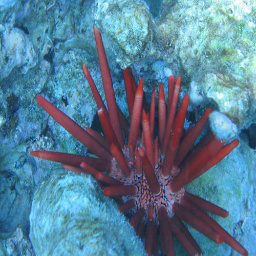

In [36]:
#take image from test set
img_n = 77

loss = nn.CrossEntropyLoss()
img_start = test_imgs[img_n]
lab = lis[test_names[img_n]]

print('lab: ',lab)
print(lab_name_n[lab])
img_start

iter n: 0
pred: tensor([328], device='cuda:0')
Power of delta:  5
iter n: 1
pred: tensor([328], device='cuda:0')
Power of delta:  0
iter n: 2
pred: tensor([328], device='cuda:0')
Power of delta:  0
iter n: 3
pred: tensor([328], device='cuda:0')
Power of delta:  0
iter n: 4
pred: tensor([328], device='cuda:0')


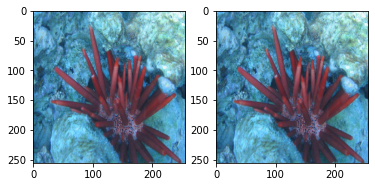

Power of delta:  0
True:  sea urchin 328
Predicted:  lionfish 396


In [47]:
#take image from all the validation set
#img_start = img_list_sorted[30]
#lab = lis[img_names_sorted[30]]

iter = 100
step = 0.01
eps = 0.5
beta = 0.99

img_test = FW_white_pair(dev, vit, img_start, lab, loss, compose,
                    n_iter = iter, step_size = step, eps = eps, beta = beta,
                    line_search = 'armijo', dist = 2, stop_condition='error')

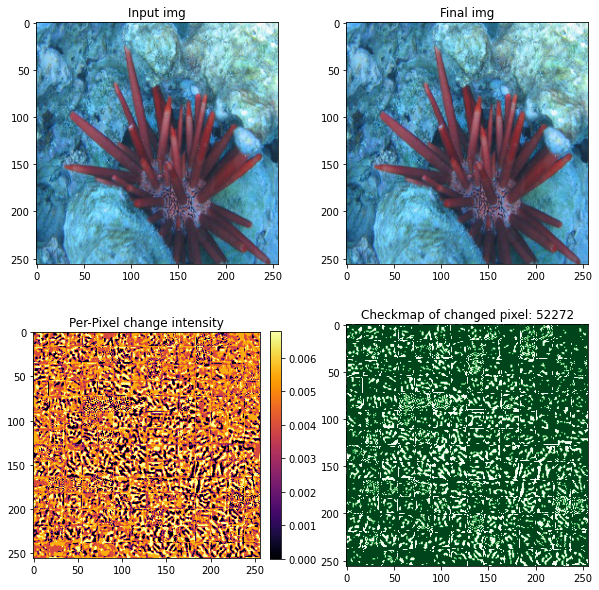

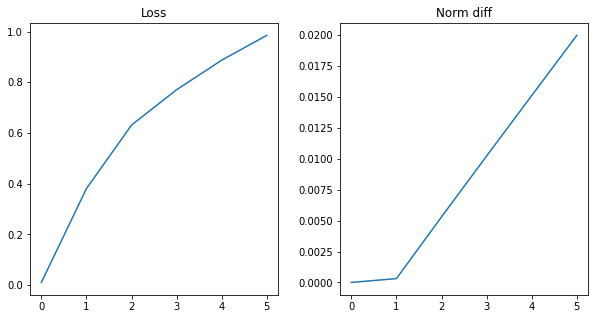

In [48]:
diff, diff_loc = difference_maps(img_start, img_test['img'], enhance = 1, space = 0.25,save_t=False)
plot_graphs(img_test, (10,5), space = 0.25)

In [ ]:
iter = 200
step = 1
eps = 0.5
beta = 0.99

img_test = FW_white_target(dev, vit, img_start, 270, loss, compose,
                    n_iter = iter, step_size = step, eps = eps, beta = beta,
                    line_search = 'armijo', dist = 'nuc', stop_condition='error',err_stop=-1)

In [ ]:
diff, diff_loc = difference_maps(img_start, img_test['img'], enhance = 1, space = 0.25,save_t=False)
plot_graphs(img_test, (10,5), space = 0.25)

In [ ]:
iter = 100
step = 0.01
eps = 5
beta = 0.99
sample_size = 10
sampling_p = 5

img_black = FW_black(dev, vit, img_start, lab, loss, compose,
                    n_iter = iter, 
                    step_size = step, 
                    sample_size = sample_size,
                    sampling_param = sampling_p,
                    eps = eps, beta = beta,
                    samp_from = "norm_dist", line_search="cumulative", dist=2, stop_condition="error", verbosity=True)

In [ ]:
diff, diff_loc = difference_maps(img_start, img_black['img'], enhance = 1, space = 0.25, save_t=False)
plot_graphs(img_black, (10,5), space = 0.25)

# FW + Attention

## FW white

In [ ]:
def FW_white_mask (dev, vit, img_start, lab, loss, compose, mask,
                  n_iter, step_size, eps, beta = 0.99, line_search = 'fixed', dist = "inf",
                  stop_condition = 'error', err_stop = 0.1, L = 1, verbosity=True):
  
  tens_lab = torch.tensor(lab, device = dev)

  obj_tens = torchvision.transforms.ToTensor()
  to_pil = torchvision.transforms.ToPILImage()

  tensor_start = obj_tens(img_start)
  tensor_start = tensor_start.to(dev)

  img_t = img_start
  tensor_t = obj_tens(img_t)
  tensor_t.to(dev)

  pred_t, grad_t, log_t, _ = pred_and_grad_single(dev, vit, img_t, lab, loss, compose, obj_tens)
  m_t = -grad_t

  loss_hist = []
  time_hist = []
  norm_diff_hist = []
  coords_ls = []
  pix_diff = []

  if (line_search == 'adaptive'):
    sup_cf = L * ((2*eps)**2)

  elif (line_search == 'cumulative'):
    counter_lab = 0

  pred_t_1 = ''
  start = time.time()
  
  for t in range(n_iter):

    #prediction, gradient and loss
    pred_t, grad_t, log_t, loss_t = pred_and_grad_single(dev, vit, img_t, lab, loss, compose, obj_tens)
  
    #momentum update
    m_t = beta * m_t + (1-beta) * -grad_t

    #LMO computation
    if(dist == "nuc"):
      v_t = LMO_nuclear(tensor_start, m_t, eps)
    elif(dist == "inf"):
      v_t = LMO(tensor_start, m_t, eps)
    elif(dist == 2):
      v_t = LMO_2(tensor_start, m_t, eps)


    #test with attention
    d_t = v_t.to(dev) - tensor_t.to(dev)
    d_t = d_t*mask.type(torch.FloatTensor).to(dev)

    if verbosity:
      #visualize adversarial image every 5 iteration
      print("iter n:", t)
      print("pred:", pred_t)
      if((t+1) % 5 == 0):
        f, axarr = plt.subplots(1,2)
        axarr[0].imshow(img_start)
        axarr[1].imshow(img_t)
        plt.show()

    loss_hist.append(loss_t)
    norm_diff_hist.append(get_norm_diff(tensor_t, tensor_start, dist))
    time_hist.append(time.time()-start)

    g_array = grad_t.clone().cpu().numpy()
    d_array = d_t.clone().cpu().numpy()
    inner = np.tensordot(g_array, d_array, axes=3).item()

    #check stop condition
    if(stop_condition == 'error'):
      if(pred_t != lab):
        print("    True: ", lab_name_n[lab], lab)
        print("    Predicted: ", lab_name_n[pred_t.item()], pred_t.item())
        return {'img':img_t,'loss_hist' :loss_hist,'time': time_hist, 'diff': norm_diff_hist, 'pixel':pix_diff, 'final_pred': pred_t, 'exit':'error'}

    elif(stop_condition == 'loss'):
      if(inner <= err_stop):
        return {'img':img_t,'loss_hist' :loss_hist,'time': time_hist, 'diff': norm_diff_hist, 'pixel':pix_diff, 'final_pred': pred_t, 'exit':'gap'}


    #line search
    if line_search == 'armijo':
      loss_t = loss(log_t.to(dev), tens_lab.unsqueeze(0))
      step_size_t = ArmijoLineSearch(vit, compose, tensor_t, tens_lab, d_t, grad_t, loss, loss_t, starting_size = step_size)

    elif line_search == 'adaptive':
      step_size_t = np.clip( (inner / sup_cf), 0, 1 )

    elif line_search == "cumulative":
      if(pred_t_1 == pred_t):
        counter_lab = counter_lab + 1
        step_size_t = step_size + np.clip((step_size * counter_lab)/2, 0, 1)
      else:
        counter_lab = 1
        step_size_t = step_size

    else:
      step_size_t = step_size

    #update
    pix_diff.append(n_pix_diff(step_size_t*d_t))
    tensor_t = (tensor_t.to(dev) + step_size_t*d_t.to(dev))
    img_t = to_pil(tensor_t)
    pred_t_1 = pred_t


  return {'img':img_t,'loss_hist' :loss_hist,'time': time_hist, 'diff': norm_diff_hist, 'pixel':pix_diff, 'final_pred': pred_t, 'exit':'max_iter'}

## FW black

In [ ]:
def FW_black_mask (dev, vit, img_start, lab, loss, compose, coords,
                  n_iter, step_size, eps, sample_size, sampling_param,  beta=0.99, line_search="fixed", dist="decepticon", 
                  samp_from = "norm_dist", stop_condition='error', err_stop = 0.1, L=1, verbosity = True):
  

  tens_lab = torch.tensor(lab, device = dev)

  obj_tens = torchvision.transforms.ToTensor()
  to_pil = torchvision.transforms.ToPILImage()

  tensor_start = obj_tens(img_start).to(dev)

  img_t = img_start
  tensor_t = obj_tens(img_t).to(dev)

  #the gradient estimation now takes also the coords
  m_t = fast_grad_est(vit, tensor_t, tens_lab, sample_size, compose, coords, sampling_param, samp_from)

  loss_hist = []
  time_hist = []
  norm_diff_hist = []
  pix_diff = []
  coords_ls = []

  if (line_search == 'adaptive'):
    sup_cf = L * ((2*eps)**2)

  elif (line_search == 'cumulative'):
    counter_lab = 0

  pred_t_1 = ''
  start = time.time()
  
  for t in range(n_iter):
    print("iter n:", t)

    #the gradient estimation now takes also the coords
    grad_t = fast_grad_est(vit, tensor_t, tens_lab, sample_size, compose, coords, sampling_param, samp_from)
    m_t = beta * m_t + (1-beta) * grad_t

    #LMO computation
    if(dist == "nuc"):
      v_t = LMO_nuclear(tensor_start, eps)
    elif(dist == "inf"):
      v_t = LMO(tensor_start, m_t, eps)
    elif(dist == 2):
      v_t = LMO_2(tensor_start, m_t, eps)
      

    d_t = v_t.to(dev) - tensor_t.to(dev)
    tensor_t = tensor_t + step_size*d_t

    img_t = to_pil(tensor_t)

    p = compose(tensor_t).unsqueeze(0).to(dev)
    pred_t, logits = vit.predict(p)
    loss_t = loss(logits[0].to(dev), tens_lab)

    loss_hist.append(loss_t.item())
    norm_diff_hist.append(get_norm_diff(tensor_t, tensor_start, dist))

    time_hist.append(time.time()-start)

    g_array = grad_t.clone().cpu().numpy()
    d_array = d_t.clone().cpu().numpy()
    inner = np.tensordot(g_array, d_array, axes=3).item()


    if(stop_condition == 'error'):
      if(pred_t != lab):
        print("    True: ", lab_name_n[lab], lab)
        print("    Predicted: ", lab_name_n[pred_t.item()], pred_t.item())
        return {'img':img_t,'loss_hist' :loss_hist,'time': time_hist, 'diff': norm_diff_hist, 'pixel':pix_diff, 'final_pred': pred_t, 'exit':'error'}


    #step size
    if line_search == 'armijo':
      loss_t = loss(logits.to(dev), tens_lab.unsqueeze(0))
      step_size_t = ArmijoLineSearch(vit, compose, tensor_t, tens_lab, d_t, grad_t, loss, loss_t, starting_size = step_size)

    elif line_search == 'adaptive':
      step_size_t = np.clip( (inner / sup_cf), 0, 1 )

    elif line_search == "cumulative":
      if(pred_t_1 == pred_t):
        counter_lab = counter_lab + 1
        step_size_t = step_size + np.clip((step_size * counter_lab)/2, 0, 1)
      else:
        counter_lab = 1
        step_size_t = step_size

    else:
      step_size_t = step_size

    pix_diff.append(n_pix_diff(step_size_t*d_t))
    tensor_t = (tensor_t.to(dev) + step_size_t*d_t.to(dev))
    img_t = to_pil(tensor_t)
    pred_t_1 = pred_t
    

  return {'img':img_t,'loss_hist' :loss_hist,'time': time_hist, 'diff': norm_diff_hist, 'pixel':pix_diff, 'final_pred': pred_t, 'exit':'max_iter'}

In [ ]:
def fast_grad_est(vit, tensor_t, lab, batch_size, compose, coords, sampling_param, samp_from = "norm_dist"):

  grad_e = 0
  lab = lab.to(dev)

  for i in range(batch_size):
    if(samp_from == "norm_dist"):
      mask = np.zeros((3,256,256))
      mask[ :, coords[1], coords[2] ] = np.random.normal(loc=0.0, scale=1.0)
      samp = torch.from_numpy(mask).type(torch.FloatTensor).to(dev)

    elif(samp_from == "unit_sphere"):
      samp = np.random.random_sample(size = tensor_t.size())
      samp /= np.linalg.norm(samp, axis = 0, ord = 2)
      samp = torch.tensor(samp).type(torch.FloatTensor).to(dev)

    point_plus = tensor_t + sampling_param*samp
    point_plus = compose(point_plus).unsqueeze(0).to(dev)
    _, log_plus = vit.predict(point_plus)
    eval_plus = loss(log_plus[0].to(dev), lab)

    point_minus = tensor_t - sampling_param*samp
    point_minus = compose(point_minus).unsqueeze(0).to(dev)
    _, log_minus = vit.predict(point_minus)
    eval_minus = loss(log_minus[0].to(dev), lab)

    grad_e = grad_e + (1/(2*sampling_param*batch_size))*((eval_plus.item() - eval_minus.item())*samp)

  return grad_e

#Execute attention

20223


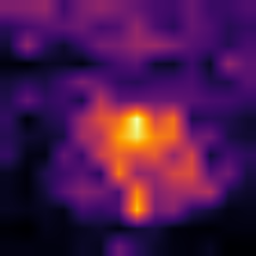

In [ ]:
print(heatmaps_names[100])
heatmaps_list[100]

In [ ]:
img_names_sorted.index(20223)

20222

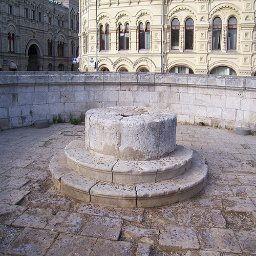

In [ ]:
img_list_sorted[20222]

In [ ]:
mask = hm_to_coords(heatmaps_list[100], treshold=0.1, coords=False)
mask = torch.from_numpy(mask).to(dev)

mask[mask>0.3] = 1
mask[mask<0.3] = 0

to_pil = torchvision.transforms.ToPILImage()
to_pil(mask)

In [ ]:
loss = nn.CrossEntropyLoss()

img_start = img_list_sorted[33728]
lab = lis[img_names_sorted[33728]]

iter = 200
step = 0.5
eps = 5
beta = 0.99

mask = hm_to_coords(heatmaps_list[-1], treshold=0.01, coords=False)
mask = torch.from_numpy(mask).to(dev)
mask[mask>0.2] = 1
mask[mask<0.2] = 0


img_white = FW_white_mask(dev, vit, img_start, lab, loss, compose,
                          mask, iter, step, eps, line_search = "armijo",
                          dist=2)

In [ ]:
diff, diff_loc = difference_maps(img_start, img_white['img'], enhance = 1, space = 0.25, save_t = False)
plot_graphs(img_white, (10,5), space = 0.25)

In [ ]:
img_start = img_list_sorted[32441]
lab = lis[img_names_sorted[32441]]

iter = 80
step = 0.5
eps = 5
beta = 0.99
sample_size = 50
sampling_p = 1


couple_idx = hm_to_coords(heatmaps_list[100], treshold=0.3, coords=True)


img_black = FW_black_mask(dev, vit, img_start, lab, loss, compose, couple_idx,
                          iter, step, eps, sample_size,
                          sampling_p, line_search = "armijo",
                          dist=2,  samp_from = "norm_dist")



In [ ]:
diff, diff_loc = difference_maps(img_start, img_black['img'], enhance = 1, space = 0.25, save_t = False)
plot_graphs(img_black, (10,5), space = 0.25)

In [ ]:
loss = nn.CrossEntropyLoss()
img_start = img_list_sorted[-1]
lab = lis[img_names_sorted[-1]]

iter = 50
step = 1e-2
eps = 1e-2
beta = 0.99


mask = hm_to_coords(heatmaps_list[-1], treshold=0.1, coords=False)
couple_idx = hm_to_coords(heatmaps_list[-1], treshold=0.1, coords=True)

img_test = FW_white_mask(dev, vit, img_start, lab, loss, compose, couple_idx, mask,
                    n_iter = iter, step_size = step, eps = eps, beta = beta,
                    line_search = 'fixed', dist = 1, stop_condition='error')

In [ ]:
diff, diff_loc = difference_maps(img_start, img_test['img'], enhance = 1, space = 0.25, save_t=False)
plot_graphs(img_test, (10,5), space = 0.25)

# TEST

In [ ]:
idx = np.random.choice(500, 100, replace=False)

In [ ]:
#run
shutil.copyfile(os.path.join(MAIN_PATH, 'test_idx'), 'test_idx')
with open('test_idx', 'rb') as f:
  test_idx = pickle.load(f)

In [ ]:
np.sort(test_idx)
#([ 20,  23,  26,  31,  35,  37,  42,  45,  47,  50,  58,  59,  64,

array([ 20,  23,  26,  31,  35,  37,  42,  45,  47,  50,  58,  59,  64,
        67,  70,  71,  73,  85,  87,  99, 101, 106, 111, 119, 121, 122,
       124, 130, 132, 139, 141, 143, 154, 158, 167, 178, 179, 195, 201,
       204, 207, 210, 211, 212, 221, 224, 230, 235, 237, 239, 247, 248,
       256, 258, 263, 264, 269, 276, 277, 280, 283, 284, 287, 291, 293,
       296, 310, 312, 313, 315, 324, 326, 330, 332, 345, 363, 370, 374,
       386, 392, 406, 409, 410, 415, 417, 430, 433, 456, 458, 460, 463,
       466, 474, 476, 482, 483, 485, 486, 493, 496])

In [ ]:
!rm -r FW_white

In [ ]:
#run WHITE and variations

variant_name = 'FW_white'
try:
  os.mkdir(variant_name)
except:
  pass

results = []

iters = [100]
lines = ['adaptive']
steps = [0.01]
epses = [0.01]
beta = 0.99
loss = nn.CrossEntropyLoss()
dist = 'inf'
total_tests = len(iters)*len(lines)*len(steps)*len(epses)
j = 0
for eps in epses:
  for step in steps:
    for line_search in lines:
      for iter in iters:
        j = j+1
        print('TEST N: '+str(j)+'/'+str(total_tests))
        test_name = generate_test_name(iter, dist, eps, line_search, step, beta)
        test_name = test_name + '_PT'
        path = os.path.join('/content', variant_name, test_name)
        os.mkdir(path)
        make_desc(iter, step, eps, dist, line_search, path, test_name, beta)
        k=0
        for i in test_idx:
          k=k+1
          print('  img:'+str(k)+'/'+str(len(test_idx)))
          #attack image
          results.append(FW_white(dev, vit, test_imgs[i], lis[test_names[i]], loss, compose,
                            n_iter = iter, step_size = step, eps = eps, beta = beta,
                            line_search = line_search, dist = dist, stop_condition='error', verbosity = False))

          #save maps
          difference_maps(test_imgs[i], results[-1]['img'], enhance = 1, space = 0.25, save = False, name=test_names[i], path=path)
          #save output dict
          with open(os.path.join(path,str(test_names[i]), str(test_names[i])+'_dict'), 'wb') as f:
            pickle.dump(results[-1], f)
        shutil.make_archive(test_name, 'zip', os.path.join(variant_name,test_name))
        shutil.copyfile(test_name+'.zip', os.path.join(MAIN_PATH, variant_name, test_name+'.zip'))


In [ ]:
#run BLACK

variant_name = 'FW_black'
try:
  os.mkdir(variant_name)
except:
  pass

results = []

iters = [50]
lines = ['armijo']
steps = [0.5]
epses = [5]
beta = 0.99
loss = nn.CrossEntropyLoss()
dist = 2

samp_size = 5
samp_norm = "norm_dist"  #'unit_sphere'
samp_p = 3

if samp_norm == 'norm_dist':
  s_tag = 'N'
else:
  s_tag = 'U'

total_tests = len(iters)*len(lines)*len(steps)*len(epses)
j = 0
for eps in epses:
  for step in steps:
    for line_search in lines:
      for iter in iters:
        j = j+1
        print('TEST N: '+str(j)+'/'+str(total_tests))
        test_name = generate_test_name(iter, dist, eps, line_search, step, beta)

        test_name = test_name+'_S'+str(samp_size)+'_F'+s_tag

        path = os.path.join('/content', variant_name, test_name)
        os.mkdir(path)
        make_desc(iter, step, eps, dist, line_search, path, test_name, beta)
        k=0
        for i in test_idx:
          k=k+1
          print('  img:'+str(k)+'/'+str(len(test_idx)))


          #attack image
          results.append(FW_black(dev, vit, test_imgs[i], lis[test_names[i]], loss, compose,
                            n_iter = iter, step_size = step, sample_size = samp_size, sampling_param = samp_p, eps = eps, beta = beta,
                            samp_from = "norm_dist", line_search = line_search, dist = dist, stop_condition='error', verbosity = False))

          #save maps
          difference_maps(test_imgs[i], results[-1]['img'], enhance = 1, space = 0.25, save = False, name=test_names[i], path=path)
          #save output dict
          with open(os.path.join(path,str(test_names[i]), str(test_names[i])+'_dict'), 'wb') as f:
            pickle.dump(results[-1], f)
        shutil.make_archive(test_name, 'zip', os.path.join(variant_name,test_name))
        shutil.copyfile(test_name+'.zip', os.path.join(MAIN_PATH,'FW_black',test_name+'.zip'))

In [ ]:
!rm -r FW_black_attention

In [ ]:
#run BLACK ATTENTION

variant_name = 'FW_black_attention'
try:
  os.mkdir(variant_name)
except:
  pass

results = []

iters = [2]
lines = ['cumulative']
steps = [0.1]
epses = [5]
beta = 0.99
loss = nn.CrossEntropyLoss()
dist = 2

samp_size = 20
samp_norm = "norm_dist"  #'unit_sphere'
samp_p = 1

if samp_norm == 'norm_dist':
  s_tag = 'N'
else:
  s_tag = 'U'

total_tests = len(iters)*len(lines)*len(steps)*len(epses)
j = 0
for eps in epses:
  for step in steps:
    for line_search in lines:
      for iter in iters:
        j = j+1
        print('TEST N: '+str(j)+'/'+str(total_tests))
        test_name = generate_test_name(iter, dist, eps, line_search, step, beta)

        test_name = test_name+'_S'+str(samp_size)+'_F'+s_tag

        path = os.path.join('/content', variant_name, test_name)
        os.mkdir(path)
        make_desc(iter, step, eps, dist, line_search, path, test_name, beta)
        k=0
        for i in test_idx:
          k=k+1
          print('  img:'+str(k)+'/'+str(len(test_idx)))

          hi = heatmaps_test_names.index(test_names[i])
          couple_idx = hm_to_coords(heatmaps_test_list[hi], treshold=0.3, coords=True)
          
          #attack image
          results.append(FW_black_mask(dev, vit, test_imgs[i], lis[test_names[i]], loss, compose, couple_idx,
                            n_iter = iter, step_size = step, sample_size = samp_size, sampling_param = samp_p, eps = eps, beta = beta,
                            samp_from = "norm_dist", line_search = line_search, dist = dist, stop_condition='error', verbosity = False))

          #save maps
          difference_maps(test_imgs[i], results[-1]['img'], enhance = 1, space = 0.25, save = False, name=test_names[i], path=path)
          #save output dict
          with open(os.path.join(path,str(test_names[i]), str(test_names[i])+'_dict'), 'wb') as f:
            pickle.dump(results[-1], f)
        shutil.make_archive(test_name, 'zip', os.path.join(variant_name,test_name))
        shutil.copyfile(test_name+'.zip', os.path.join(MAIN_PATH,'FW_black_attention',test_name+'.zip'))

In [ ]:
!rm -r FW_white_attention

In [ ]:
#run WHITE ATTENTION

variant_name = 'FW_white_attention'
try:
  os.mkdir(variant_name)
except:
  pass

results = []

iters = [100]
lines = ['adaptive']
steps = [0.01]
epses = [0.01]
beta = 0.99
loss = nn.CrossEntropyLoss()
dist = 'inf'

mask_thresh = [0.3]


total_tests = len(iters)*len(lines)*len(steps)*len(epses)*len(mask_thresh)
j = 0

for thresh in mask_thresh:
  for eps in epses:
    for step in steps:
      for line_search in lines:
        for iter in iters:
          j = j+1
          print('TEST N: '+str(j)+'/'+str(total_tests))
          test_name = generate_test_name(iter, dist, eps, line_search, step, beta)

          test_name = test_name+'_MSK'+str(thresh)

          path = os.path.join('/content', variant_name, test_name)
          os.mkdir(path)
          make_desc(iter, step, eps, dist, line_search, path, test_name, beta)
          k=0
          for i in test_idx:
            k=k+1
            print('  img:'+str(k)+'/'+str(len(test_idx)))

            hi = heatmaps_test_names.index(test_names[i])
            mask = hm_to_coords(heatmaps_test_list[hi], treshold=thresh, coords=False)
            mask = torch.from_numpy(mask).to(dev)
            
            #attack image
            results.append(FW_white_mask(dev, vit, test_imgs[i], lis[test_names[i]], loss, compose, mask,
                            n_iter = iter, step_size = step,  eps = eps, beta = beta,
                            line_search = line_search, dist = dist, stop_condition='error', verbosity = False))
            

            #save maps
            difference_maps(test_imgs[i], results[-1]['img'], enhance = 1, space = 0.25, save = False, name=test_names[i], path=path)
            #save output dict
            with open(os.path.join(path,str(test_names[i]), str(test_names[i])+'_dict'), 'wb') as f:
              pickle.dump(results[-1], f)
          shutil.make_archive(test_name, 'zip', os.path.join(variant_name,test_name))
          shutil.copyfile(test_name+'.zip', os.path.join(MAIN_PATH,'FW_white_attention',test_name+'.zip'))

#Results

In [ ]:
import os, shutil
from google.colab import drive
import pickle
import torch
import os
from google.colab import output
import numpy as np
import matplotlib.pyplot as plt
import copy
import cv2

In [ ]:
with open('409_dict', 'rb') as f:
  dic = pickle.load(f)
dic['time']

In [ ]:
def get_error_rate(line, test_dicts=test_dicts):

  tmp = {}

  for d in test_dicts:
    if d['LINE_SEARCH'] == line:
      rate = 0
      for im in d['RESULT_DICTS']:
        if im['exit'] == 'error':
          rate += 1
      tmp[d['NAME']] = (d['EPS'],rate/100)

  error_rates = {
    
    'L1': [],
    'L2': [],
    'INF': [],
    'NUC': []
  }

  sorted = {
    
    'L1': [],
    'L2': [],
    'INF': [],
    'NUC': []
  }
  for e in tmp.keys():
    norm = e.split('_')[1]
    error_rates[norm].append(tmp[e])

  for n in error_rates.keys():
    epses = []
    for i in range(len(error_rates[n])):
      epses.append(error_rates[n][i][0])
    idx_max = epses.index(max(epses))
    idx_min = epses.index(min(epses))
    idx_mid = [0,1,2]
    idx_mid.remove(idx_max)
    idx_mid.remove(idx_min)
    idx_mid = idx_mid[0]
    
    sorted[n].append(error_rates[n][idx_min])
    sorted[n].append(error_rates[n][idx_mid])
    sorted[n].append(error_rates[n][idx_max])
    #print(idx_max)

  
  return sorted

In [ ]:
def plot_error_rate(error_rates, line):
  labels = list(error_rates.keys())

  values = np.zeros((4,3))
  for i in range(len(labels)):
    for j in range(3):
      values[i,j] = error_rates[labels[i]][j][1]

  x = np.arange(len(labels))  # the label locations
  prova = [-0.25,0,0.25]
  width = 0.20  # the width of the bars

  rects = []

  fig, ax = plt.subplots()



  for i in range(values.shape[0]):
    rects.append(ax.bar(x[i]+prova, values[i], width, label=labels[i]))


  ax.set_xticks(x, minor=False)
  ax.set_xticks(x, minor=True)
  ax.set_ylim([0,1])
  ax.set_xticklabels(labels)
  ax.set_ylabel('error rate')
  ax.set_xlabel('norm')
  ax.set_title('Error rates using '+line+' stepsize')

  #ax.legend()

  fig.tight_layout()



  plt.show()


In [ ]:
drive.mount('/content/drive')

zip_path = '/content/drive/MyDrive/UNIPD_Projects/Decepticon/FW_target/'
ex_path = '/content/tests_target/'
!mkdir tests_target

names = os.listdir(zip_path)

for i,n in enumerate(names):
  output.clear()
  if 'M99' in n:
    print('Loading test ' +str(i+1)+'/'+str(len(names)))
    path = ex_path+n.replace('.zip','')
    os.mkdir(path)
    shutil.unpack_archive(zip_path+n,path)

test_n = os.listdir(ex_path)

Loading test 10/10


In [ ]:
test_n = os.listdir(ex_path)

In [ ]:
test_dicts = []
for i,n in enumerate(test_n):
  path = ex_path + n + '/'
  f_names = os.listdir(path)
  test_dicts.append({'NAME': n})
  img_dict_list = []
  for f in f_names:
    
    if '.txt' in f:
      with open(path+f) as file:
        lines = file.readlines()
      for l in lines:
        pair = l.rstrip().split(': ')
        try:
          test_dicts[i][pair[0]] = float(pair[1])
        except ValueError:
          test_dicts[i][pair[0]] = pair[1]
    else:
      with open(path+f+'/'+f+'_dict', 'rb') as handle:
        tmp = pickle.load(handle)
        tmp['img_idx'] = int(f)
        img_dict_list.append(tmp)
    test_dicts[i]['RESULT_DICTS'] = img_dict_list


In [ ]:
for t in test_dicts:
  print(t['NAME'])

150_NUC_E1_ARM5_M99
150_INF_E01_CUM05_M99
150_L2_E3_CUM05_M99
150_INF_E01_ARM5_M99
150_NUC_E1_CUM05_M99
150_L2_E3_FIX05_M99
150_INF_E01_FIX05_M99
150_NUC_E1_FIX05_M99
150_L2_E3_ARM5_M99
150_L2_E3_ARM05_M99


In [ ]:
test_dicts[1]['RESULT_DICTS'][0].keys()

dict_keys(['img', 'loss_hist', 'time', 'diff', 'pixel', 'final_pred', 'exit', 'img_idx'])

error


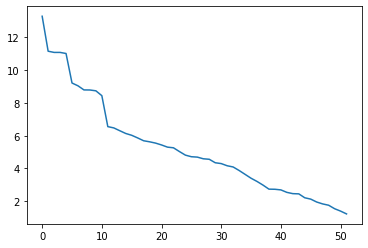

In [ ]:
for i,im in enumerate(test_dicts[1]['RESULT_DICTS']):
  if im['img_idx'] == 511:
    plt.plot(im['loss_hist'])
    print(im['exit'])

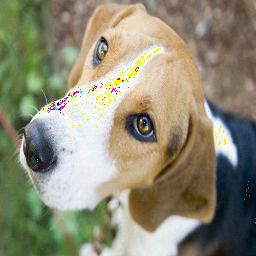

In [ ]:
test_dicts[1]['RESULT_DICTS'][70]['img']

In [ ]:
error_PW = {}

for t in test_dicts:
  sum = 0
  for im in t['RESULT_DICTS']:
    idx = im['img_idx']
    for i in range(len(test_names)):
      if test_names[i] == idx:
        img_name = i
    sum += count_pix(test_dicts[-1]['RESULT_DICTS'][99]['img'], test_imgs[img_name])


  error_PW[t['NAME']] = sum/65536

In [ ]:
error_PW

{'100_L2_E3_CUM01_M99_MSK0.3': 99.17448425292969,
 '100_INF_E01_CUM01_M99_MSK0.3': 99.17448425292969,
 '100_L2_E3_ARM5_M99_MSK0.3': 99.17448425292969,
 '100_INF_E01_ADA01_M99_MSK0.3': 99.17448425292969}

In [ ]:
error_PW = {}

for t in test_dicts:
  sum = 0
  for im in t['RESULT_DICTS']:
    if im['exit'] == 'error':
      sum += 1


  error_PW[t['NAME']] = sum/100

In [ ]:
error_PW

{'100_INF_E01_ARM5_M99': 0.89,
 '100_L1_E5_FIX01_M99': 0.09,
 '100_L1_E10_ADA01_M99': 0.08,
 '100_NUC_E1_ARM5_M99': 0.54,
 '100_L2_E5_ADA01_M99': 0.79,
 '100_L2_E3_ARM5_M99': 0.9,
 '100_NUC_E3_ADA01_M99': 0.49,
 '100_NUC_E1_CUM01_M99': 0.54,
 '100_L2_E1_ADA01_M99': 0.79,
 '100_L2_E5_ARM5_M99': 0.9,
 '100_INF_E01_ADA01_M99_PT': 0.89,
 '100_INF_E01_CUM01_M99': 0.9,
 '100_NUC_E5_ARM5_M99': 0.69,
 '100_L1_E5_ADA01_M99': 0.08,
 '100_INF_E001_CUM01_M99': 0.77,
 '100_L2_E1_ARM5_M99': 0.84,
 '100_L1_E3_ARM5_M99': 0.05,
 '100_L1_E3_CUM01_M99': 0.07,
 '100_NUC_E5_FIX01_M99': 0.62,
 '100_L2_E3_CUM01_M99': 0.9,
 '100_L1_E5_CUM01_M99': 0.07,
 '100_L2_E5_CUM01_M99': 0.92,
 '100_NUC_E3_ARM5_M99': 0.65,
 '100_L1_E3_FIX01_M99': 0.05,
 '100_INF_E01_ADA01_M99': 0.9,
 '100_L2_E3_FIX01_M99': 0.8,
 '100_INF_E1_ARM5_M99': 0.99,
 '100_L2_E1_CUM01_M99': 0.86,
 '100_L1_E10_FIX01_M99': 0.15,
 '100_L1_E3_ADA01_M99': 0.05,
 '100_INF_E1_FIX01_M99': 0.99,
 '100_L2_E1_FIX01_M99': 0.78,
 '100_L1_E10_ARM5_M99': 0.06,
 

In [ ]:
def count_pix(img,ori):
  a_img = np.array(img)
  a_ori = np.array(ori)

  diff = a_img - a_ori

  diff = np.sum(np.abs(diff), axis=2)

  return np.sum(diff != 0)

In [ ]:
error_PW = {}

for t in test_dicts:
  sum = 0
  for im in t['RESULT_DICTS']:
    idx = im['img_idx']
    for i in range(len(test_names)):
      if test_names[i] == idx:
        img_name = i
    
    arr_start = np.array(test_imgs[img_name])
    arr_end = np.array(im['img'])

    mat = np.zeros([256,256])

    for i in range(256):
      for j in range(256):
        mat[i,j] = L2Norm(arr_start[i,j]/255, arr_end[i,j]/255)


    sum += np.sum(mat)


  error_PW[t['NAME']] = sum/65536100

In [ ]:
error_PW

{'100_L2_E3_FIX01_M99': 0.8,
 '100_L2_E3_ARM01_M99': 0.76,
 '100_NUC_E3_FIX01_M99': 0.58,
 '100_INF_E01_CUM01_M99': 1.0,
 '100_L2_E3_CUM01_M99': 0.98,
 '100_INF_E01_FIX01_M99': 0.86,
 '100_NUC_E3_ARM01_M99': 0.4,
 '100_INF_E01_ARM01_M99': 0.71,
 '100_NUC_E3_CUM01_M99': 0.85}

In [ ]:
error_PW

{'100_L2_E3_FIX01_M99': 99.99899291992188,
 '100_L2_E3_ARM01_M99': 99.99899291992188,
 '100_NUC_E3_FIX01_M99': 99.99899291992188,
 '100_INF_E01_CUM01_M99': 99.99899291992188,
 '100_L2_E3_CUM01_M99': 99.99899291992188,
 '100_INF_E01_FIX01_M99': 99.99899291992188,
 '100_NUC_E3_ARM01_M99': 99.99899291992188,
 '100_INF_E01_ARM01_M99': 99.99899291992188,
 '100_NUC_E3_CUM01_M99': 99.99899291992188}

In [ ]:
error_PW

{'100_L2_E3_FIX01_M99': 0.0010998339822118944,
 '100_L2_E3_ARM01_M99': 0.0005023867452675025,
 '100_NUC_E3_FIX01_M99': 0.0012278337640781666,
 '100_INF_E01_CUM01_M99': 0.004578556740551733,
 '100_L2_E3_CUM01_M99': 0.0037630317141846537,
 '100_INF_E01_FIX01_M99': 0.002357251937123138,
 '100_NUC_E3_ARM01_M99': 0.0006632228144361037,
 '100_INF_E01_ARM01_M99': 0.0004278883278972927,
 '100_NUC_E3_CUM01_M99': 0.0062501078587666676}

In [ ]:
test_dicts[0].keys()

dict_keys(['NAME', 'RESULT_DICTS', 'MAX_ITER', 'NORM', 'EPS', 'LINE_SEARCH', 'STEP_SIZE', 'MOMENTUM'])

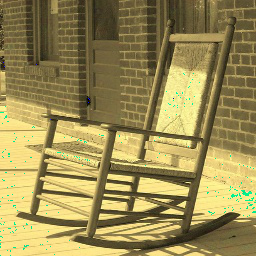

In [ ]:
test_dicts[0]['RESULT_DICTS'][0]['img']

In [ ]:
count_pix(test_dicts[-1]['RESULT_DICTS'][99]['img'], test_imgs[img_name])

55141